# Look for enrichments of GWAS disorder genes

In [16]:
%cd work/notebooks

# Import modules and R
import numpy as np, pandas as pd
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

# Import local code
import sys
sys.path.append('/home/jovyan/work/code')
from gradientVersion import *
from processing_helpers import *
from analysis_helpers import *
from enrichments import *
%R source("../code/Rplots.R");
%R source("../code/brainPlots.R");

[Errno 2] No such file or directory: 'work/notebooks'
/home/jovyan/work/notebooks
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [239]:
def get_gwas(filename='li2018'):
    df = pd.read_csv(f"../data/gwas/{filename}.csv")
    df = (df.melt(var_name='label', value_name='gene').dropna()
          .assign(gene = lambda x: x['gene'].str.replace('\\..*','', regex=True))) #drop variants
    return df

gwas_genes = get_gwas('trubetskoy2022')
# get_gwas('reay2020')
# get_gwas('grove2019_wray2018_pardinas2018')
# get_gwas('matoba2020_als2022_ripke2020')

In [17]:
dme_3d_ds5 = gradientVersion(approach='dm').fit('hcp_3donors_ds5')
weights = dme_3d_ds5.weights.iloc[:,:3]
nulls = shuffle_gene_weights(weights, n=5000, rank=False)


New gradients version: method=dm, kernel=normalized_angle, sparsity=0, data=hcp_3donors_ds5


In [245]:
gwas_genes_dict = {
    'grove2019_wray2018_pardinas2018': get_gwas('grove2019_wray2018_pardinas2018'),
    # 'pardinas2018_other': get_gwas('pardinas2018_other'),
    'matoba2020_als2022_ripke2020': get_gwas('matoba2020_als2022_ripke2020'),
    'li2018': get_gwas('li2018'),
    'li2018_hiC_strict': get_gwas('li2018_hiC_strict'),
    'reay2020': get_gwas('reay2020'),
    # 'pain2019_yang2021_trubetskoy2022': get_gwas('pain2019_yang2021_trubetskoy2022')
}

gwas_stats_dict = {
    name: compute_null_p(*compute_enrichments(weights, nulls, gwas_genes, posneg='abs'))
    for name, gwas_genes in gwas_genes_dict.items()
}

In [260]:
# gwas_genes.pop('pain2019_yang2021_trubetskoy2022')
gwas_genes = get_gwas('hammerschlag2020_yang2021_trubetskoy2022')
gwas_stats_dict['hammerschlag2020_yang2021_trubetskoy2022']=compute_null_p(*compute_enrichments(weights, nulls, gwas_genes, posneg='abs'))

In [262]:
gwas_stats = (pd.concat(gwas_stats_dict).reset_index(0).rename({'level_0':'data'}, axis=1)
              .assign(label = lambda x: [f"{label}\n({n_matches}/{n_genes})" for label, n_matches, n_genes in
                                        zip(x['label'], x['n_matches'], x['n_genes'])]))
gwas_stats.head(10)

,data,label,G,pct,true_mean,null_mean,null_std,z,pos,p,q,sig,n_genes,n_matches
0,grove2019_wray2018_pardinas2018,ASD\n(9/15),G1,0.5776,0.010642,0.010301,0.001500,0.227628,True,0.8448,0.95040,False,15,9
1,grove2019_wray2018_pardinas2018,ASD\n(9/15),G2,0.8972,0.011930,0.009099,0.002184,1.295906,True,0.2056,0.58230,False,15,9
2,grove2019_wray2018_pardinas2018,ASD\n(9/15),G3,0.3850,0.008243,0.008971,0.002177,-0.334560,False,0.7700,0.95040,False,15,9
3,grove2019_wray2018_pardinas2018,MDD\n(62/153),G1,0.7378,0.010647,0.010283,0.000563,0.645934,True,0.5244,0.78660,False,153,62
4,grove2019_wray2018_pardinas2018,MDD\n(62/153),G2,0.1226,0.008141,0.009103,0.000831,-1.157680,False,0.2452,0.58230,False,153,62
5,grove2019_wray2018_pardinas2018,MDD\n(62/153),G3,0.8166,0.009787,0.009002,0.000848,0.924790,True,0.3668,0.66024,False,153,62
6,grove2019_wray2018_pardinas2018,SCZ\n(11/22),G1,0.4952,0.010320,0.010293,0.001338,0.020250,False,0.9904,0.99040,False,22,11
7,grove2019_wray2018_pardinas2018,SCZ\n(11/22),G2,0.8706,0.011406,0.009123,0.001996,1.144110,True,0.2588,0.58230,False,22,11
8,grove2019_wray2018_pardinas2018,SCZ\n(11/22),G3,0.0038,0.004169,0.009024,0.001998,-2.429129,False,0.0076,0.06840,False,22,11
0,matoba2020_als2022_ripke2020,ASD\n(106/372),G1,0.7744,0.010611,0.010294,0.000425,0.746127,True,0.4512,0.67680,False,372,106


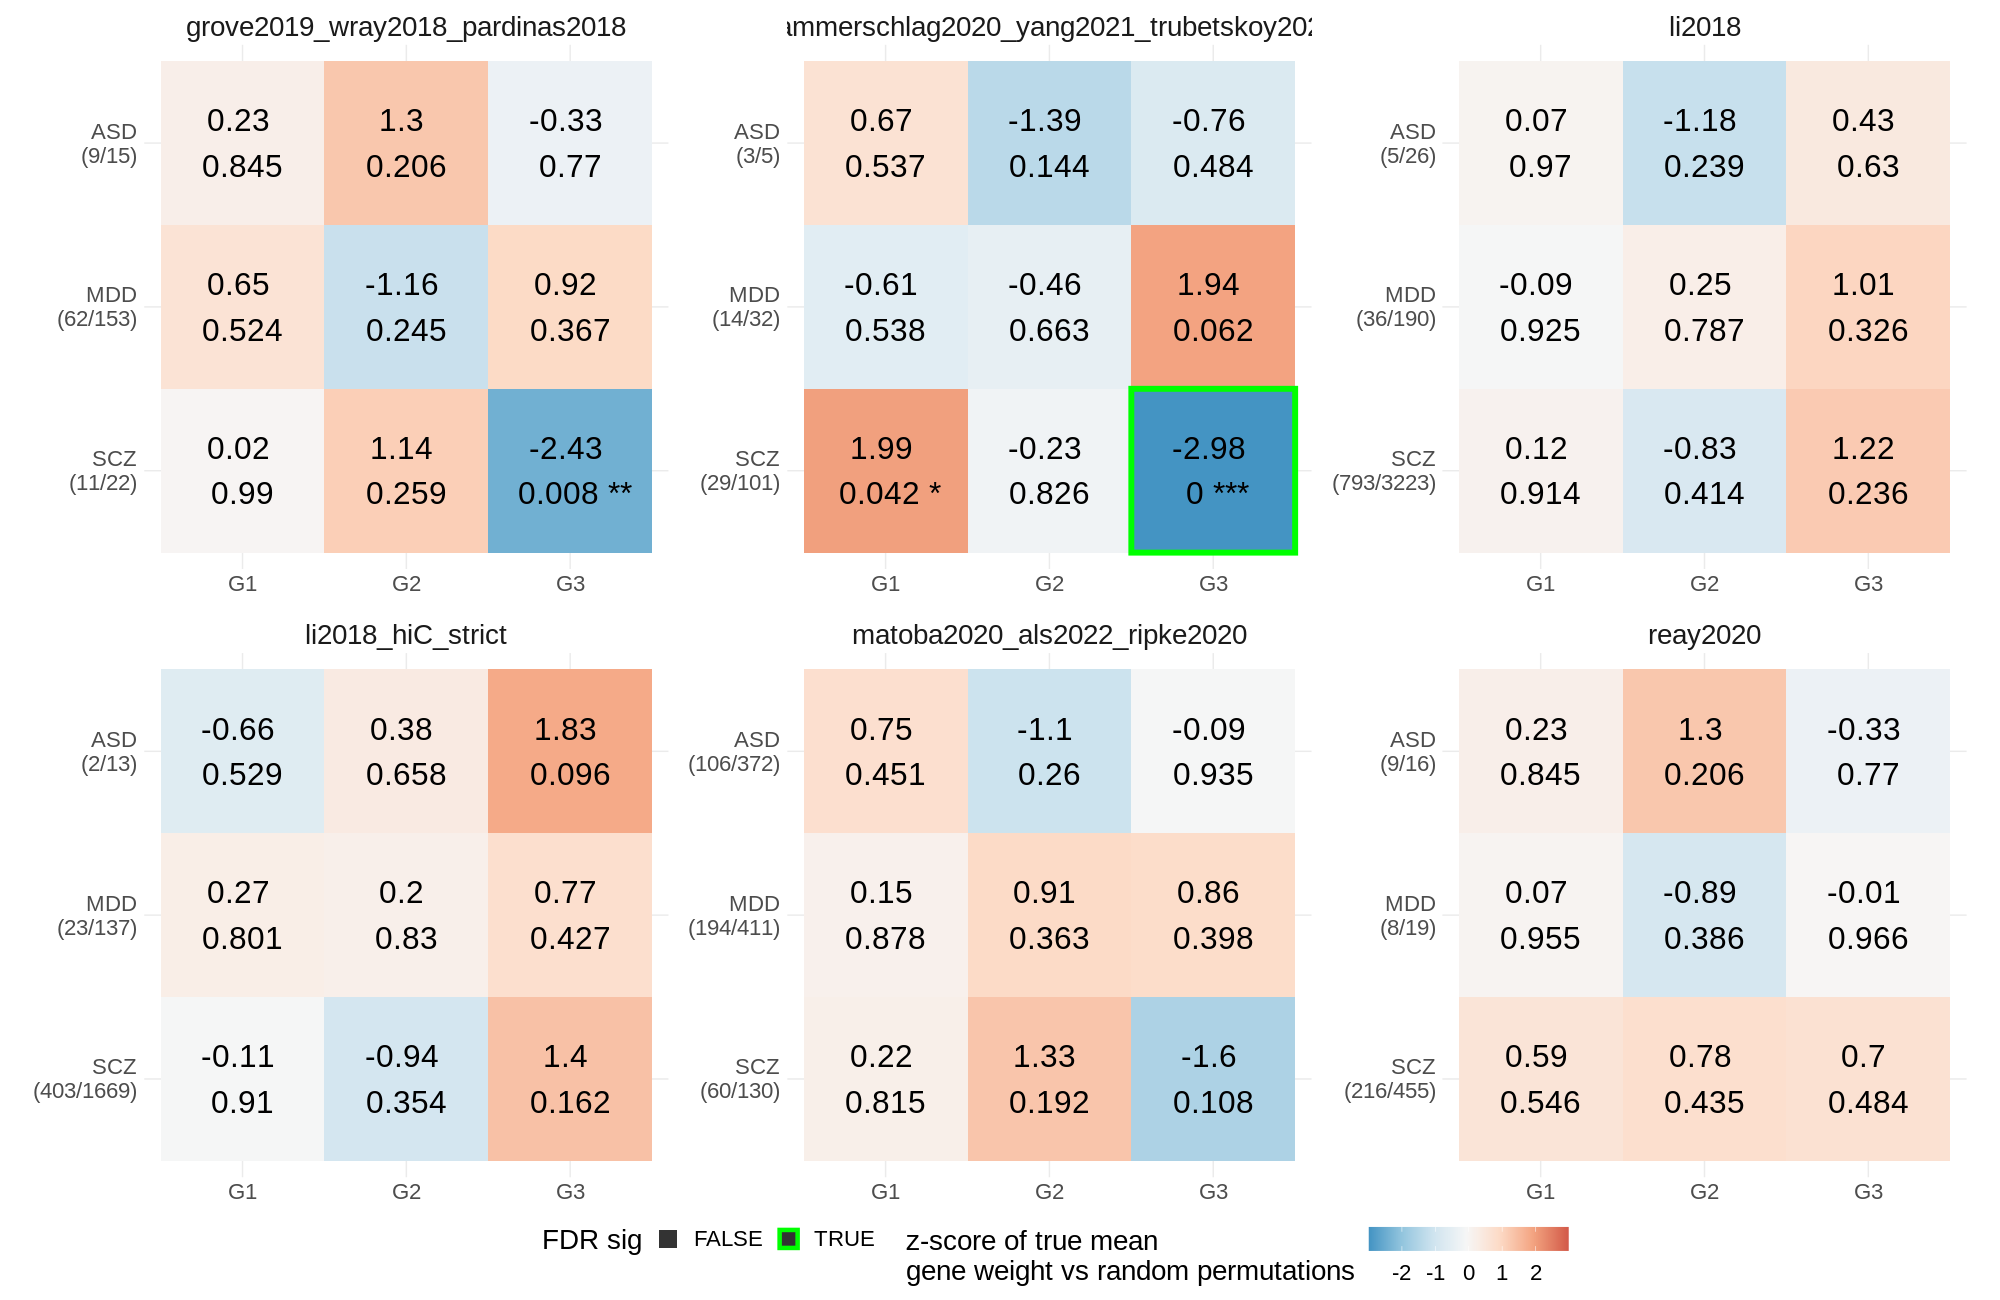

In [263]:
%%R -i gwas_stats -w 20 -h 13 --units in -r 100
source("../code/enrichmentsPlots.R")
gwas_stats %>% rename(version = data) %>% arrange(version) %>% 
plot_enrichment_heatmaps(scales='free') + theme(legend.position='bottom') +
guides(fill=guide_colourbar(title='z-score of true mean\ngene weight vs random permutations', barwidth=10))

In [232]:
a = gwas_genes_dict['grove2019_wray2018_pardinas2018'].query("label=='SCZ'").set_index('gene').drop('label', axis=1).assign(pardinas=True)
b = gwas_genes_dict['matoba2020_als2022_ripke2020'].query("label=='SCZ'").set_index('gene').drop('label', axis=1).assign(ripke=True)

In [238]:
pd.concat([a,b], axis=1).assign(count=1).fillna(0).groupby(['pardinas','ripke']).sum()

count
pardinas ripke       
0.0      1.0      119
1.0      0.0       11
         1.0       11